In [ ]:
# Python

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
from pandas_datareader.data import DataReader

import statsmodels.api as sm
import statsmodels.stats as sms
import statsmodels.stats.diagnostic as smsd

import matplotlib.pyplot as plt
import matplotlib.image as img
from PIL import Image
%matplotlib inline

from IPython import display
from IPython.display import clear_output
import time as tm

import cv2

np.set_printoptions(suppress=True)
np.random.seed(23)

# R

%load_ext rpy2.ipython

import rpy2
import rpy2.robjects as robjects

from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

%R install.packages("strucchange")
%R library(tidyverse)
%R library(stringi)
%R require(strucchange)

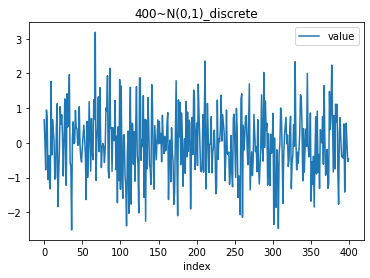

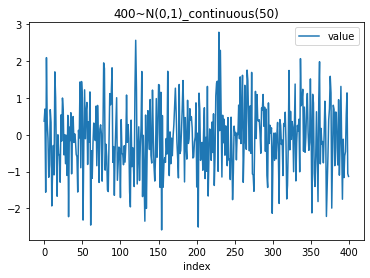

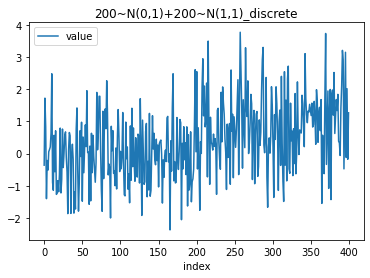

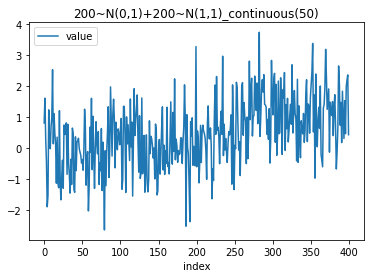

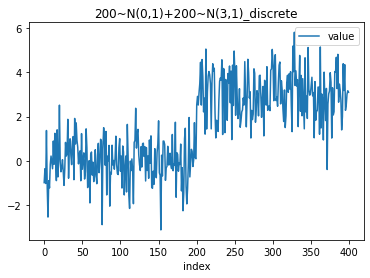

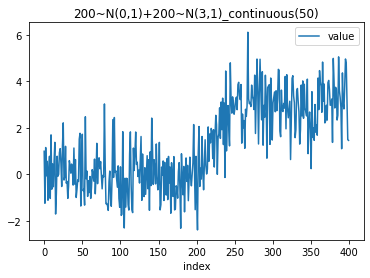

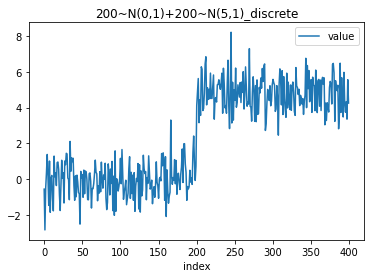

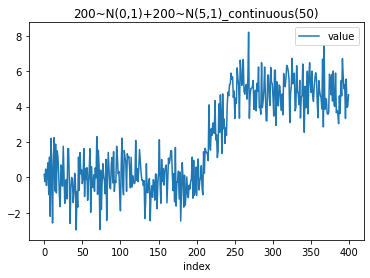

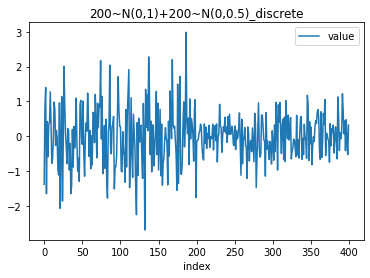

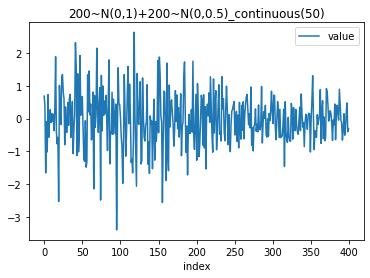

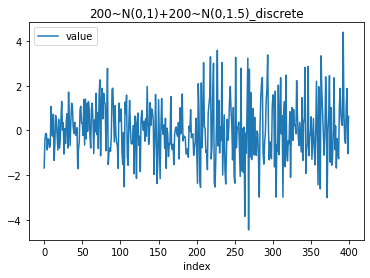

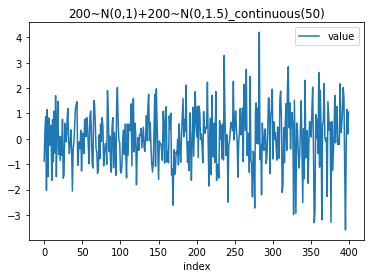

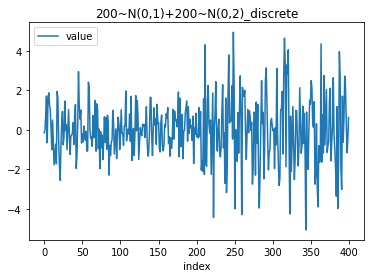

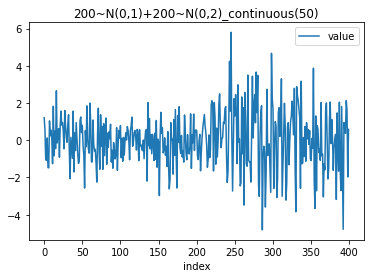

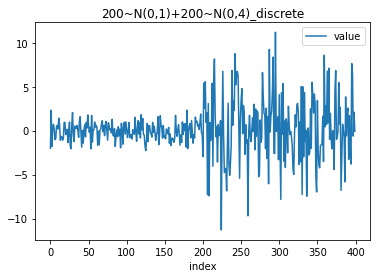

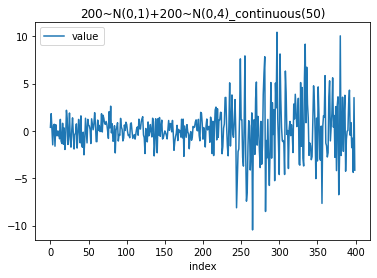

In [25]:
def gen_tseries(label, cnt=50):
    p = []
    for token in label.split('+'):
        size, dist = token.split('~')
        
        size = int(size)
        mid = float(dist.split('(')[1].split(',')[0])
        sigma = float(dist.split(',')[1].split(')')[0])
        
        p.append([mid, sigma, size])
    
    y = np.random.normal(*p[0])
    
    for i in range(1, len(p)):
        if cnt > 0:
            d_mid = (p[i][0] - p[i - 1][0]) / cnt
            d_sigma = (p[i][1] - p[i - 1][1]) / cnt

            for j in range(0, cnt):
                temp_y = np.random.normal(p[i - 1][0] + d_mid * j, p[i - 1][1] + d_sigma * j, 1)
                y = np.concatenate([y, temp_y])
        
        p[i][2] -= cnt
        temp_y = np.random.normal(*p[i])
        y = np.concatenate([y, temp_y])
    
    return y


def build_series(labels):
    lst = []
    for label in labels:
        lst.append(pd.DataFrame(gen_tseries(label, 0), columns = ['value']).reset_index())
        lst[-1].name = label + "_discrete"
        lst.append(pd.DataFrame(gen_tseries(label, 50), columns = ['value']).reset_index())
        lst[-1].name = label + "_continuous(50)"
    return lst


labels = [
    '400~N(0,1)',
    '200~N(0,1)+200~N(1,1)',
    '200~N(0,1)+200~N(3,1)',
    '200~N(0,1)+200~N(5,1)',
    
    '200~N(0,1)+200~N(0,0.5)',
    '200~N(0,1)+200~N(0,1.5)',
    '200~N(0,1)+200~N(0,2)',
    '200~N(0,1)+200~N(0,4)',

    #'50~N(0,1)+100~N(5,1)+50~N(1,1)+100~N(3,1)',
]

dfs = build_series(labels)

def Plot(df, title=None):
    if title is None:
        title = df.name
    
    df.plot('index', 'value', title=title)
    plt.show()

for i, df in enumerate(dfs):
    Plot(df, df.name)
    # sm.add_constant(df).to_csv("csv/" + str(i).zfill(3) + "_" + str(df.name) + ".csv")

In [26]:
#CUSUM test
def CUSUM(df, path="./CUSUM.png"):
    model = sm.RecursiveLS(df["value"], df["index"])
    res = model.fit()

    fig = res.plot_cusum()
    plt.savefig(path)
    plt.close(fig)

    return res.cusum


#CUSUM of Squares test
def CUSUMS(df, path="./CUSUMS.png"):
    model = sm.RecursiveLS(df["value"], df["index"])
    res = model.fit()
    
    fig = res.plot_cusum_squares()
    plt.savefig(path)
    plt.close(fig)
    
    return res.cusum_squares


#CUSUM and CUSUM of Squares tests
def CUSUM_all(df, cusum_path="./CUSUM.png", cusums_path="./CUSUMS.png"):
    model = sm.RecursiveLS(df["value"], df["index"])
    res = model.fit()

    fig = res.plot_cusum()
    plt.savefig(cusum_path, facecolor=fig.get_facecolor(), edgecolor='none')
    plt.close(fig)

    fig = res.plot_cusum_squares()
    plt.savefig(cusums_path)
    plt.close(fig)

    return res.cusum, res.cusum_squares

In [27]:
#Quandt Likelihood Ratio test
robjects.r('''
        QLR <- function(df, title, full_path) {
            res <- Fstats(value ~ index + 1, data=df)

            png(filename=full_path)
            # if (sctest(res, type = "supF")$p.value >= 0.05) {
            #     par(bg="palegreen")
            # } else {
            #     par(bg="lightsalmon")
            # }
            plot(res, main=title)
            dev.off()
            
            if (all(is.na(res$breakpoint))) {
                return(list())
            }
            return(res$breakpoint)
        }
        ''')
QLR_inner = robjects.globalenv['QLR']

def QLR(df, title="QLR", full_path="./QLR.png"):
    return list(map(int, QLR_inner(df, title, full_path)))

def QLR_plot(df, title):
    %R -i df -i title plot(Fstats(value ~ index + 1, data=df), main=title)


#Bai-Perron test
robjects.r('''
        BaiPerron <- function(df, title, full_path) {
            res <- breakpoints(value ~ index + 1, data=df)

            png(filename=full_path)
            # if (all(is.na(res$breakpoint))) {
            #     par(bg="palegreen")
            # } else {
            #     par(bg="lightsalmon")
            # }
            plot(res, main=title)
            dev.off()

            if (all(is.na(res$breakpoint))) {
                return(list())
            }
            return(res$breakpoint)
        }
        ''')
BaiPerron_inner = robjects.globalenv['BaiPerron']

def BaiPerron(df, title="Bai-Perron", full_path_bp="./BaiPerron.png", full_path_bic="./BaiPerron_bic.png"):
    points = list(map(int, BaiPerron_inner(df, title, full_path_bic)))
    
    ax = df.plot('index', 'value', title=title)
    # if points == []:
    #     ax.set_facecolor("palegreen")
    # else:
    #     ax.set_facecolor("lightsalmon")
    for point in points:
        plt.axvline(x=point, color="black")
    plt.savefig(full_path_bp)
    plt.close()

    return points

def BaiPerron_plot(df, title):
    %R -i df -i title plot(breakpoints(value ~ index + 1, data=df), main=title)

In [28]:
def OnlinePlot(base_df, begin, end, step):
    base_df.plot('index', 'value', title=base_df.name)
    plt.savefig("./DataFull.png")
    plt.close()
    
    for to in range(begin, end, step):
        df = base_df.iloc[:to,:]
        
        df.plot('index', 'value', title=base_df.name)
        plt.savefig("./DataSlice.png")
        plt.close()

        cusum, cusums = CUSUM_all(df)
        qlr = QLR(df)
        bp = BaiPerron(df)

        clear_output(True)

        fig, axes = plt.subplots(nrows=2, ncols=3)
        fig.set_size_inches(20, 12)
        fig.suptitle("Max index: " + str(to))

        im = img.imread("./DataFull.png")
        axes[0, 0].imshow(im)
        axes[0, 0].axis('off')

        im = img.imread("./BaiPerron.png")
        axes[0, 1].imshow(im)
        axes[0, 1].axis('off')

        im = img.imread("./CUSUM.png")
        axes[0, 2].imshow(im)
        axes[0, 2].axis('off')

        im = img.imread("./BaiPerron_bic.png")
        axes[1, 0].imshow(im)
        axes[1, 0].axis('off')

        im = img.imread("./QLR.png")
        axes[1, 1].imshow(im)
        axes[1, 1].axis('off')

        im = img.imread("./CUSUMS.png")
        axes[1, 2].imshow(im)
        axes[1, 2].axis('off')

        plt.show()

In [29]:
# OnlinePlot(dfs[7], 210, 224, 1)

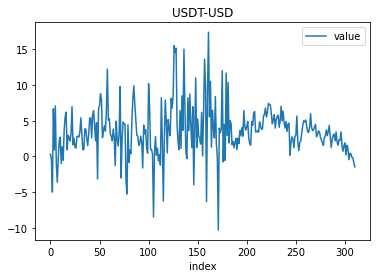

In [30]:
csv = pd.read_csv("USDT-USD.csv")
csv = csv.iloc[50:-5]
df = pd.DataFrame(csv["Close"].values * 10000 - 10000, columns = ['value']).reset_index()
df.name = "USDT-USD"
Plot(df, df.name)

In [31]:
def OnlinePlot_video(base_df, begin, end=None, step=None):
    if end is None:
        end = len(base_df)
    if step is None:
        step = 1
    
    base_df.plot('index', 'value', title=base_df.name)
    plt.savefig("./DataFull.png")
    plt.close()
    
    # fig.get_size_inches() * fig.dpi
    video = cv2.VideoWriter('video.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 5, (1440, 864))

    for to in range(begin, end, step):
        df = base_df.iloc[:to,:]
        
        df.plot('index', 'value', title=base_df.name)
        plt.savefig("./DataSlice.png")
        plt.close()

        cusum, cusums = CUSUM_all(df)
        qlr = QLR(df)
        bp = BaiPerron(df)

        clear_output(True)

        fig, axes = plt.subplots(nrows=2, ncols=3)
        fig.set_size_inches(20, 12)
        fig.suptitle("Max index: " + str(to))

        im = img.imread("./DataFull.png")
        axes[0, 0].imshow(im)
        axes[0, 0].axis('off')

        im = img.imread("./BaiPerron.png")
        axes[0, 1].imshow(im)
        axes[0, 1].axis('off')

        im = img.imread("./CUSUM.png")
        axes[0, 2].imshow(im)
        axes[0, 2].axis('off')

        im = img.imread("./BaiPerron_bic.png")
        axes[1, 0].imshow(im)
        axes[1, 0].axis('off')

        im = img.imread("./QLR.png")
        axes[1, 1].imshow(im)
        axes[1, 1].axis('off')

        im = img.imread("./CUSUMS.png")
        axes[1, 2].imshow(im)
        axes[1, 2].axis('off')

        plt.savefig("./temp_img.png", edgecolor='none')
        plt.show()
        
        video.write(cv2.imread("./temp_img.png"))
    
    video.release()
    cv2.destroyAllWindows()

In [32]:
# OnlinePlot_video(df, 50, len(df), 1)

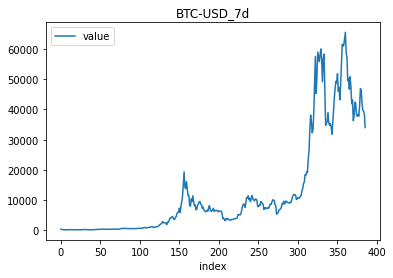

In [33]:
csv = pd.read_csv("BTC_USD_01012009_01052022_7d.csv")
csv = csv.iloc[:]
df = pd.DataFrame(csv["<CLOSE>"].values, columns = ['value']).reset_index()
df.name = "BTC-USD_7d"
Plot(df, df.name)

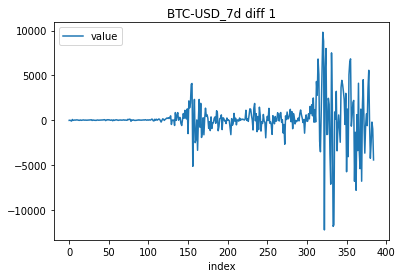

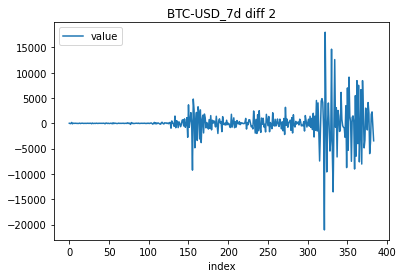

In [34]:
diff_1 = []
for i in range(1, len(df)):
    diff_1.append(df["value"].values[i] - df["value"].values[i - 1])

df_1 = pd.DataFrame(diff_1, columns = ['value']).reset_index()
df_1.name = df.name + " diff 1"
Plot(df_1)

diff_2 = []
for i in range(1, len(diff_1)):
    diff_2.append(diff_1[i] - diff_1[i - 1])

df_2 = pd.DataFrame(diff_2, columns = ['value']).reset_index()
df_2.name = df.name + " diff 2"
Plot(df_2)

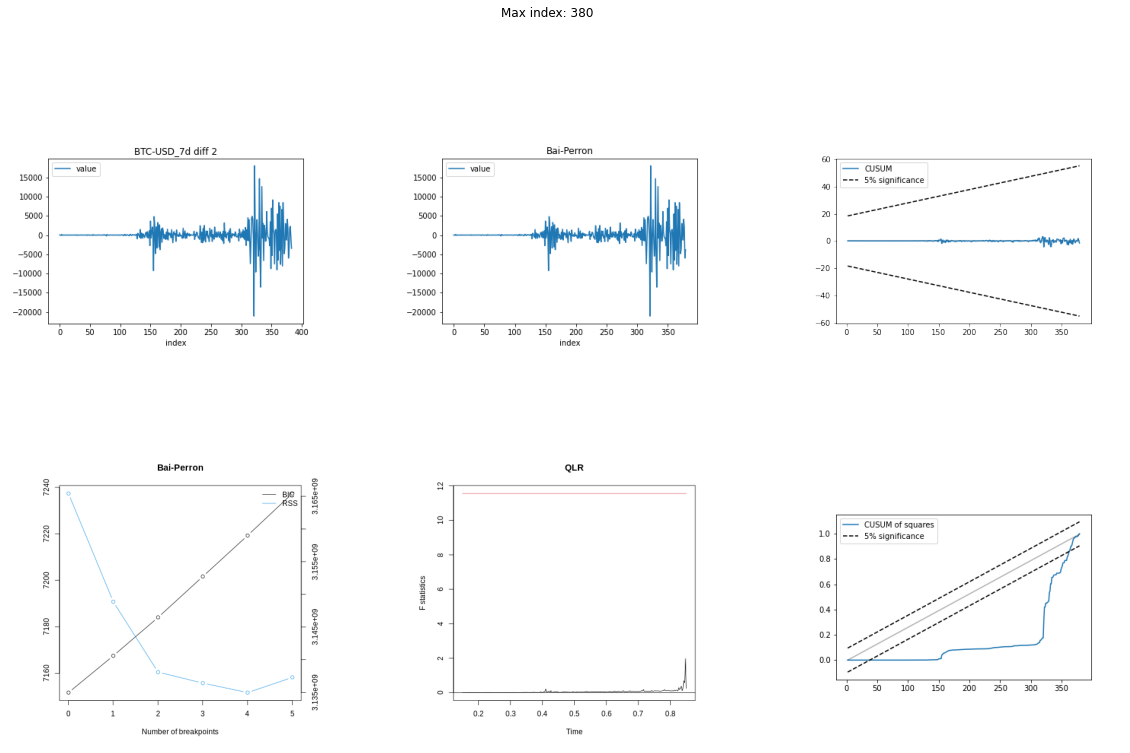

In [35]:
OnlinePlot_video(df_2, 50, step=5)